## PROYECTO : 
## Optimización Inteligente del peletizado de Planta Ávicola en Estado No Estacionario

## I. Descripción de la planta 

La planta de peletizado, procesa mezcla de piensos (alimento balanceado de aves) para producir pellets.\
Tipo de proceso: Continuo\
Estado : No estacionario \
Variables: no lineales 

Etapas del proceso:
- Acondicionamiento, peletizado y enfriamiento

Objetivos de Optimización:
* Minimizar consumo de energía
* Minimizar Finos
* Maximizar productividad
* Cumplir estándares de calidad 

Restricciones (estándares de calidad):
* Tamaño de Pellet (DGM): 3900 - 4100 
* Durabilidad de Pellet (PDI): > 91 %

### 🔧 ETAPA 1: Entrenamiento y Selección del Mejor Modelo Deep CQL (Offline Inicial)
📌 Objetivo: Obtener un modelo robusto, generalizable y profesional para decisiones de control óptimas en la planta industrial simulada.\
Se entrena el agente con el dataset histórico y se selecciona el mejor modelo según score y métricas de validación cruzada

#### ✅ ETAPA 1.1: Preparación del Dataset y Configuración Inicial del Modelo

1.1 Preparación y Carga de Datos Reales

In [1]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from d3rlpy.dataset import MDPDataset
from d3rlpy.algos import CQLConfig
from d3rlpy.models.encoders import DefaultEncoderFactory
from d3rlpy.models.q_functions import MeanQFunctionFactory
from copy import deepcopy


from sklearn.metrics import mean_squared_error
import joblib
import time
import matplotlib.pyplot as plt

In [2]:
# Directorio y carga
directorio_actual = os.getcwd()
archivo_csv = os.path.join(directorio_actual, "DPta_CarEngMxI&Q_6.0md1.csv")
data_Pelt = pd.read_csv(archivo_csv, encoding='latin1', sep=';')

In [3]:
# Revisar datos cargados
print(data_Pelt.head())

       Fecha  F_Alim  T_Alim  T_Vap   P_Vap  T_Acond  t_ret  H_Pelt  T_Pelt  \
0  2/01/2019   22.00   23.90  170.0  108.50    74.00  98.00   11.80   30.65   
1  2/01/2019   22.52   23.80  171.0  111.00    77.50  92.00   12.20   28.40   
2  3/01/2019   23.93   25.04  170.0  106.50    72.38  99.75   11.78   31.83   
3  3/01/2019   27.91   24.91  170.0  110.00    78.14  92.86   11.97   29.51   
4  4/01/2019   28.87   26.50  170.0  107.75    74.50  95.00   12.73   33.58   

     Fn    PDI      DGM   Prodt    Q_Vap  M_Vap  H_Add  
0  3.70  94.40  3582.00  91.887   897.07   2.15   8.91  
1  5.50  92.00  3494.00  89.425   984.26   2.38   9.55  
2  2.74  94.43  3852.00  92.252   922.01   2.20   8.42  
3  3.89  92.72  3753.14  90.557  1209.15   2.91   9.45  
4  6.73  92.18  3136.00  90.761  1127.85   2.70   8.55  


In [4]:
#Verificación de datos completos
print("Datos completos:", data_Pelt.isnull().sum().sum() == 0)

Datos completos: True


#### Análisis de datos

In [6]:
 #Eliminar la columna "Fecha" si existe
if 'Fecha' in data_Pelt.columns:
    data_Pelt = data_Pelt.drop(columns=['Fecha'])

In [7]:
# Calcular matriz de correlación lineal (Pearson)
corr_matrix = data_Pelt.corr(method='pearson')

In [9]:
# Obtener pares únicos de correlaciones (sin duplicados ni autodiagonales)
corr_pairs = (
    corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
    .stack()
    .reset_index()
)
corr_pairs.columns = ['Variable 1', 'Variable 2', 'Correlación']
corr_pairs['AbsCorr'] = corr_pairs['Correlación'].abs()

In [10]:
# Filtrar las correlaciones fuertes (por encima de 0.75)
correlaciones_fuertes = corr_pairs[corr_pairs['AbsCorr'] >= 0.75]
correlaciones_fuertes = correlaciones_fuertes.sort_values(by='AbsCorr', ascending=False)

c:\Users\USER\AppData\Local\Programs\Python\Python312\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


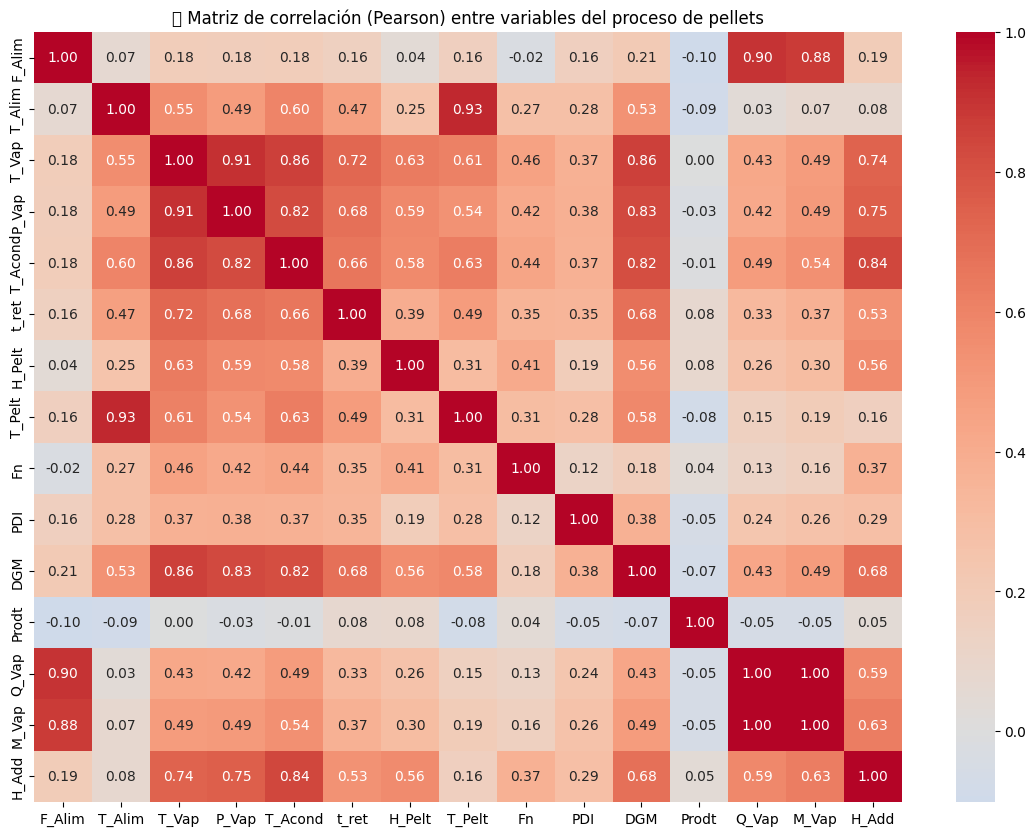

In [8]:
#Visualizar la matriz de correlación
plt.figure(figsize=(14, 10))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", center=0)
plt.title("📈 Matriz de correlación (Pearson) entre variables del proceso de pellets")
plt.show()

In [11]:
# Mostrar resultados con interpretación
print("📊 PAREJAS DE VARIABLES CON MAYOR CORRELACIÓN (|r| ≥ 0.75):\n")
for _, fila in correlaciones_fuertes.iterrows():
    v1 = fila['Variable 1']
    v2 = fila['Variable 2']
    corr = fila['Correlación']
    tipo = "positiva" if corr > 0 else "negativa"

    print(f"🔸 {v1} y {v2} → Correlación {tipo} fuerte (r = {corr:.2f})")

    # Interpretación automática
    if tipo == "positiva":
        print(f"    ↪ A medida que {v1} aumenta, también tiende a aumentar {v2}, y viceversa.")
    else:
        print(f"    ↪ A medida que {v1} aumenta, {v2} tiende a disminuir, y viceversa.")
    print()

📊 PAREJAS DE VARIABLES CON MAYOR CORRELACIÓN (|r| ≥ 0.75):

🔸 Q_Vap y M_Vap → Correlación positiva fuerte (r = 1.00)
    ↪ A medida que Q_Vap aumenta, también tiende a aumentar M_Vap, y viceversa.

🔸 T_Alim y T_Pelt → Correlación positiva fuerte (r = 0.93)
    ↪ A medida que T_Alim aumenta, también tiende a aumentar T_Pelt, y viceversa.

🔸 T_Vap y P_Vap → Correlación positiva fuerte (r = 0.91)
    ↪ A medida que T_Vap aumenta, también tiende a aumentar P_Vap, y viceversa.

🔸 F_Alim y Q_Vap → Correlación positiva fuerte (r = 0.90)
    ↪ A medida que F_Alim aumenta, también tiende a aumentar Q_Vap, y viceversa.

🔸 F_Alim y M_Vap → Correlación positiva fuerte (r = 0.88)
    ↪ A medida que F_Alim aumenta, también tiende a aumentar M_Vap, y viceversa.

🔸 T_Vap y T_Acond → Correlación positiva fuerte (r = 0.86)
    ↪ A medida que T_Vap aumenta, también tiende a aumentar T_Acond, y viceversa.

🔸 T_Vap y DGM → Correlación positiva fuerte (r = 0.86)
    ↪ A medida que T_Vap aumenta, también tie

- Definición de Columnas relevantes

In [3]:
# Definir columnas relevantes
observation_columns = ['F_Alim', 'T_Alim', 'T_Vap', 'P_Vap', 'T_Acond', 't_ret',
                       'H_Pelt', 'T_Pelt', 'M_Vap', 'H_Add']
action_columns = ['Q_Vap', 'Fn', 'Prodt']
meta_columns = ['PDI', 'DGM']

1.2 Normalización y Escalado del Dataset

In [4]:
scaler_obs = MinMaxScaler()
scaler_act = MinMaxScaler()
scaler_mets = MinMaxScaler()

obs = scaler_obs.fit_transform(data_Pelt[observation_columns].astype(np.float32))
act = scaler_act.fit_transform(data_Pelt[action_columns].astype(np.float32))
mets = scaler_mets.fit_transform(data_Pelt[meta_columns].astype(np.float32))


1.3 Definición de Recompensa Simulada Realista

In [5]:
def calcular_recompensa(row):
    prodt = round(row['Prodt'], 3)
    q_vap = round(row['Q_Vap'], 3)
    fn = round(row['Fn'], 3)
    pdi = round(row['PDI'], 2)
    dgm = round(row['DGM'], 1)

    penalizacion_fn = max(0, (fn - 5) * 20)
    penalizacion_qvap = q_vap * 0.01
    penalizacion_pdi = 0 if pdi > 91 else 1000
    penalizacion_dgm = 0 if 3900 <= dgm <= 4100 else 1000

    recompensa = prodt * 10 - penalizacion_fn - penalizacion_qvap - penalizacion_pdi - penalizacion_dgm
    return round(recompensa, 4)

In [6]:
# Calcular recompensa para cada fila
rewards = data_Pelt.apply(calcular_recompensa, axis=1).values

In [7]:
# Crear señal de finalización artificial cada 100 pasos
terminals = np.zeros(len(data_Pelt))
terminals[99::100] = 1

1.4 Construcción del Dataset MDP para Deep CQL

In [8]:
dataset = MDPDataset(
    observations=obs.astype(np.float32),
    actions=act.astype(np.float32),
    rewards=rewards.astype(np.float32),
    terminals=terminals.astype(bool)
)

2025-05-12 11:16.55 [info     ] Signatures have been automatically determined. action_signature=Signature(dtype=[dtype('float32')], shape=[(3,)]) observation_signature=Signature(dtype=[dtype('float32')], shape=[(10,)]) reward_signature=Signature(dtype=[dtype('float32')], shape=[(1,)])
2025-05-12 11:16.55 [info     ] Action-space has been automatically determined. action_space=<ActionSpace.CONTINUOUS: 1>
2025-05-12 11:16.55 [info     ] Action size has been automatically determined. action_size=3


1.5 Configuración del Modelo Deep CQL

In [9]:
# Configuración básica del agente
cql_config = CQLConfig(batch_size=64)
cql_config.encoder_factory = DefaultEncoderFactory([256, 256, 256])
cql_config.q_func_factory = MeanQFunctionFactory()

deep_cql = cql_config.create()

1.6 Creación de Carpeta para Guardar Resultados

In [16]:
os.makedirs("model_DeepCQL3_Pelt", exist_ok=True)

1.7 Funciones Auxiliares de Validación y Evaluación

In [17]:
def es_valido(fila):
    return (
        (fila['Fn'] >= 0) & (fila['Q_Vap'] >= 0) & (fila['Prodt'] >= 0) &
        (fila['Fn'] < 5) & (fila['PDI'] > 91) &
        (3900 <= fila['DGM'] <= 4100)
    )

In [18]:
def forzar_a_valor_real(pred, df_base, cols_pred, historial_indices=set()):
    """
    Devuelve la fila más cercana a la predicción:
    - Si hay filas válidas (cumplen restricciones), retorna la válida más cercana.
    - Si no hay válidas, retorna la más cercana aunque no sea válida.
    """
    distancias = np.linalg.norm(df_base[cols_pred].values - pred, axis=1)
    df_temp = df_base.copy()
    df_temp['distancia'] = distancias

    # Filtrar filas no repetidas
    df_temp = df_temp[~df_temp.index.isin(historial_indices)]

    if df_temp.empty:
        return None

    # Intentar primero con válidas
    df_validas = df_temp[df_temp.apply(es_valido, axis=1)]
    if not df_validas.empty:
        mejor_fila = df_validas.sort_values('distancia').iloc[0]
    else:
        mejor_fila = df_temp.sort_values('distancia').iloc[0]

    historial_indices.add(mejor_fila.name)
    return mejor_fila


✅ Beneficio de este diseño
Esta versión:

No requiere un parámetro opcional como aplicar_restricciones.

Siempre ejecuta la validación, pero de forma inteligente y flexible.

Prioriza las soluciones que cumplen restricciones

1.8 Estado Global de Entrenamiento y Mejores Resultados

In [19]:
estado = {
    'resultados_epochs': [],              #Lista de DataFrames con todos los resultados de cada epoch
    'mejores': [],                        # Lista de las mejores filas válidas de cada epoch
    'mejor_score': -np.inf,               # Máximo score visto hasta ahora (para comparar y guardar nuevo modelo)
    'indices_mejores_globales': set()     # Índices ya seleccionados como "mejores" para evitar duplicados
}

Este código de estado es necesario para que:

Se acumulen los resultados de cada epoch ('resultados_epochs').

Se guarden todos los mejores cumplimientos válidos por epoch ('mejores').

Se registre el mejor score global alcanzado hasta el momento ('mejor_score').

Se evite repetir registros ya evaluados en mejores cumplimientos ('indices_mejores_globales' como conjunto de índices únicos).



1.9 Registro de Mejores Resultados por Época

In [ ]:
def registrar_mejor_resultado(algo, epoch, total_step, metrics=None):
    acciones_pred = algo.predict(obs)
    estado_epoch, mejores_epoch = [], []
    historial_indices = set()

    for accion_pred in acciones_pred:
        accion_real = scaler_act.inverse_transform(accion_pred.reshape(1, -1)).ravel()
        fila_real = forzar_a_valor_real(accion_real, data_Pelt, action_columns, historial_indices)

        if fila_real is not None:
            fila_real = fila_real.copy()
            fila_real['epoch'] = epoch
            fila_real['step'] = total_step
            fila_real['score'] = calcular_recompensa(fila_real)
            estado_epoch.append(fila_real)

            if es_valido(fila_real) and fila_real.name not in estado['indices_mejores_globales']:
                mejores_epoch.append(fila_real)
                estado['indices_mejores_globales'].add(fila_real.name)

    if estado_epoch:
        resultados_df = pd.DataFrame(estado_epoch)
        estado['resultados_epochs'].append(resultados_df)

        # Exportar todos los resultados de la epoch (append)
        resultados_df.to_csv("model_DeepCQL3_Pelt/resultados_validacion.csv", mode='a', sep=';', float_format="%.2f", encoding='latin-1', index=False, header=not os.path.exists("resultados_validacion.csv"))

        from IPython.display import display, HTML
        print(f"\n📊 [Epoch {epoch}] Resultados completos de la epoch ({len(resultados_df)} filas):")
        display(HTML(resultados_df.to_html(index=False, max_rows=20)))

        if mejores_epoch:
            mejores_df = pd.DataFrame(mejores_epoch)
            mejor = mejores_df.sort_values(by='score', ascending=False).iloc[0]
            estado['mejores'].append(mejor)

            # Exportar cumplimientos válidos de esta epoch (append)
            mejores_df.to_csv("model_DeepCQL3_Pelt/cumplimientos.csv", mode='a', sep=';', index=False, float_format="%.2f", encoding='latin-1', header=not os.path.exists("cumplimientos.csv"))

            columnas_a_mostrar = [
                'F_Alim', 'T_Alim', 'T_Vap', 'P_Vap', 'T_Acond', 't_ret',
                'H_Pelt', 'T_Pelt', 'Fn', 'PDI', 'DGM', 'Prodt', 'Q_Vap',
                'M_Vap', 'H_Add', 'score'
            ]
            print(f"\n✅ [Epoch {epoch}] Mejor cumplimiento real:")
            display(HTML(mejor[columnas_a_mostrar].to_frame().T.to_html()))

            if mejor['score'] > estado['mejor_score']:
                estado['mejor_score'] = mejor['score']
                print(f"🎯 Nuevo mejor modelo con score: {estado['mejor_score']:.4f}")

                # Guardar el mejor modelo
                algo.save_model("model_DeepCQL3_Pelt/mejor_modelo.pt")
                algo.save_policy("model_DeepCQL3_Pelt/mejor_actor.pt")
                algo.save_policy("model_DeepCQL3_Pelt/mejor_critic.pt")

                # Guardar mejor cumplimiento global como CSV único
                mejor[columnas_a_mostrar + ['epoch', 'step']].to_frame().T.to_csv("model_DeepCQL3_Pelt/mejor_cumplimiento.csv", sep=';', index=False, float_format="%.2f", encoding='latin-1')
                


✅ Resultado esperado\
Con esta modificación:

estado_epoch contendrá todos los resultados generados, válidos o no.

mejores_epoch seguirá filtrando por es_valido, como se desea.

Por tanto:

resultados.csv contendrá todas las predicciones evaluadas.

cumplimientos.csv contendrá solo los resultados válidos (que cumplen las normas ECAS u otras restricciones).

- Función registrar_mejor_resultado para que:

Guarde automáticamente los resultados de cada epoch en resultados_validacion.csv (modo append).

Guarde automáticamente los cumplimientos válidos de cada epoch en mejores_cumplimientos.csv (modo append).

Guarde el mejor cumplimiento global en mejor_cumplimiento.csv (sobrescribiéndolo solo cuando se encuentra un nuevo mejor score).

📂 Archivos generados automáticamente\
resultados_validacion.csv: todos los resultados de cada epoch.

cumplimientos.csv: solo los cumplimientos válidos nuevos.

mejor_cumplimiento.csv: el mejor cumplimiento global (sobrescrito si mejora).

Resumen\
Esta subetapa incluyó:
- Lectura y carga de los datos reales (2.Dat-Pta_CompletoReal.csv)
- Conversión a formato MDPDataset de d3rlpy
- Definición y configuración del modelo CQL con encoder_factory='default', scaler, n_action_samples, etc.
- Creación del entorno para validación externa
- Definición de la función registrar_mejor_resultado(...) para validación y guardado automático

📚 Referencias bibliográficas (Norma Vancouver)\
Fujimoto S, Meger D, Precup D. Offline Reinforcement Learning: Tutorial, Review, and Perspectives on Open Problems. arXiv preprint arXiv:2005.01643. 2020.

D3RLpy Documentation – Deep Offline Reinforcement Learning. Disponible en: https://d3rlpy.readthedocs.io/

Sutton RS, Barto AG. Reinforcement Learning: An Introduction. 2nd ed. MIT Press; 2018.

OpenAI. Spinning Up in Deep RL. Disponible en: https://spinningup.openai.com/

Ghassemi M, Oakden-Rayner L, Beam AL. The false hope of current approaches to explainable artificial intelligence in health care. Lancet Digit Health. 2021;3(11):e745-e750.

#### ✅ ETAPA 1.2: Entrenamiento del Modelo con Validación Cruzada y Early Stopping

Entrenamiento con selección y guardado automático del mejor modelo

Paso 1: Instancia del entorno antes del bucle de entrenamiento

In [21]:
import d3rlpy
print(d3rlpy.__version__)

2.8.1


In [22]:
from d3rlpy.dataset import MDPDataset

from d3rlpy.algos import CQL
import time

In [23]:
# --- Parámetros de entrenamiento ---
#max_epochs = 20

#total_steps = 15000  # Total steps a repartir entre epochs
#steps_per_epoch = total_steps // max_epochs
inicio_entrenamiento = time.time()

mejor_score_anterior = -np.inf
epochs_sin_mejora = 0
early_stop_patience = 5
best_model = None

max_epochs = 10
steps_per_epoch = 10000

In [24]:
for epoch in range(1, max_epochs + 1):
    print(f"\n🚀 Entrenando Epoch {epoch} / {max_epochs}...")

    deep_cql.fit(dataset, n_steps=steps_per_epoch)
    
    # Validación cruzada interna o externa
    registrar_mejor_resultado(deep_cql, epoch=epoch, total_step=epoch * steps_per_epoch)

    # Score actual registrado en tu estructura "estado"
    score_actual = estado['mejor_score']

    if score_actual > mejor_score_anterior:
        mejor_score_anterior = score_actual
        epochs_sin_mejora = 0

        print(f"✅ Nuevo mejor modelo con score: {score_actual:.4f}. Guardando...")

        # Guardar el modelo como mejor hasta ahora (puede ser deep copy)
        best_model = deepcopy(deep_cql)

    else:
        epochs_sin_mejora += 1
        print(f"⏸ No hay mejora en el score. Epochs sin mejora: {epochs_sin_mejora}")

    # Early stopping
    if epochs_sin_mejora >= early_stop_patience:
        print("⛔ Se detiene entrenamiento por early stopping.")
        break

# Guardar el mejor modelo encontrado
if best_model:
    import joblib
    joblib.dump(best_model, "model_DeepCQL3_Pelt/best_model_deep_cql.pkl")
    print("✅ Modelo final guardado como 'best_model_deep_cql.pkl'")

fin_entrenamiento = time.time()
print(f"\n⏱ Tiempo total de entrenamiento: {(fin_entrenamiento - inicio_entrenamiento):.2f} segundos")



🚀 Entrenando Epoch 1 / 10...
2025-05-12 12:55.16 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float32')], shape=[(10,)]), action_signature=Signature(dtype=[dtype('float32')], shape=[(3,)]), reward_signature=Signature(dtype=[dtype('float32')], shape=[(1,)]), action_space=<ActionSpace.CONTINUOUS: 1>, action_size=3)


2025-05-12 12:55.16 [debug    ] Building models...            
2025-05-12 12:55.21 [debug    ] Models have been built.       
2025-05-12 12:55.21 [info     ] Directory is created at d3rlpy_logs\CQL_20250512125521
2025-05-12 12:55.21 [info     ] Parameters                     params={'observation_shape': [10], 'action_size': 3, 'config': {'type': 'cql', 'params': {'batch_size': 64, 'gamma': 0.99, 'observation_scaler': {'type': 'none', 'params': {}}, 'action_scaler': {'type': 'none', 'params': {}}, 'reward_scaler': {'type': 'none', 'params': {}}, 'compile_graph': False, 'actor_learning_rate': 0.0001, 'critic_learning_rate': 0.0003, 'temp_learning_rate': 0.0001, 'alpha_learning_rate': 0.0001, 'actor_optim_factory': {'type': 'adam', 'params': {'clip_grad_norm': None, 'lr_scheduler_factory': {'type': 'none', 'params': {}}, 'betas': [0.9, 0.999], 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}}, 'critic_optim_factory': {'type': 'adam', 'params': {'clip_grad_norm': None, 'lr_scheduler_fac

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2025-05-12 13:06.20 [info     ] CQL_20250512125521: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0013530492544174195, 'time_algorithm_update': 0.0638706372499466, 'critic_loss': 26991322.312146876, 'conservative_loss': 33563.981581534885, 'alpha': 2.142973643088341, 'actor_loss': -27211.037058096874, 'temp': 1.8172689043939114, 'temp_loss': -15.569543439845368, 'time_step': 0.06554993784427643} step=10000
2025-05-12 13:06.20 [info     ] Model parameters are saved to d3rlpy_logs\CQL_20250512125521\model_10000.d3

📊 [Epoch 1] Resultados completos de la epoch (3179 filas):


Fecha,F_Alim,T_Alim,T_Vap,P_Vap,T_Acond,t_ret,H_Pelt,T_Pelt,Fn,PDI,DGM,Prodt,Q_Vap,M_Vap,H_Add,distancia,epoch,step,score
17/07/2023,23.44,22.15,150.00,100.00,39.00,95.00,11.90,25.30,2.30,93.50,3930.00,88.073,321.46,0.75,3.11,123.416036,1,10000,877.5154
8/09/2022,15.71,24.40,170.00,110.00,72.00,95.00,11.80,27.40,4.00,92.20,3943.00,88.043,608.62,1.47,8.54,394.619567,1,10000,874.3438
2/05/2019,16.00,26.35,170.00,110.00,73.50,95.00,11.70,32.40,2.90,91.80,3974.50,93.458,614.00,1.48,8.46,386.264035,1,10000,928.4400
1/05/2021,16.20,26.60,170.00,110.00,76.00,95.00,12.10,29.70,2.00,92.40,4029.00,88.988,651.34,1.57,8.83,263.486490,1,10000,883.3666
11/04/2020,15.43,23.95,171.25,110.75,76.00,105.00,12.33,27.83,2.65,92.05,3953.50,94.695,653.66,1.58,9.28,360.154846,1,10000,940.4134
1/09/2023,26.00,24.50,170.00,110.00,55.50,95.00,11.93,30.60,2.75,92.35,3919.00,95.382,655.99,1.58,5.73,435.379211,1,10000,947.2601
7/09/2022,16.80,20.00,170.00,110.00,74.50,95.00,11.90,23.00,2.95,92.40,3959.75,90.966,745.20,1.79,9.65,418.875723,1,10000,902.2080
14/12/2020,18.81,21.97,170.00,110.00,71.17,96.67,11.42,25.65,2.65,91.70,4053.00,77.132,753.22,1.81,8.80,490.704525,1,10000,763.7878
22/04/2019,17.72,24.64,170.00,100.00,77.00,95.00,11.72,30.04,2.48,92.72,3922.00,90.430,755.14,1.77,9.07,544.988692,1,10000,896.7486
19/12/2020,19.20,23.60,170.00,110.00,73.00,95.00,11.90,27.40,2.70,92.60,4038.00,78.211,771.96,1.86,8.83,562.473639,1,10000,774.3904



✅ [Epoch 1] Mejor cumplimiento real:


,F_Alim,T_Alim,T_Vap,P_Vap,T_Acond,t_ret,H_Pelt,T_Pelt,Fn,PDI,DGM,Prodt,Q_Vap,M_Vap,H_Add,score
489,33.22,21.2,172.67,109.67,78.0,95.0,12.1,26.4,2.47,92.2,3987.0,97.502,1535.72,3.7,10.01,959.6628


🎯 Nuevo mejor modelo con score: 959.6628
✅ Nuevo mejor modelo con score: 959.6628. Guardando...

🚀 Entrenando Epoch 2 / 10...
2025-05-12 13:08.19 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float32')], shape=[(10,)]), action_signature=Signature(dtype=[dtype('float32')], shape=[(3,)]), reward_signature=Signature(dtype=[dtype('float32')], shape=[(1,)]), action_space=<ActionSpace.CONTINUOUS: 1>, action_size=3)
2025-05-12 13:08.19 [warning  ] Skip building models since they're already built.
2025-05-12 13:08.19 [info     ] Directory is created at d3rlpy_logs\CQL_20250512130819
2025-05-12 13:08.19 [info     ] Parameters                     params={'observation_shape': [10], 'action_size': 3, 'config': {'type': 'cql', 'params': {'batch_size': 64, 'gamma': 0.99, 'observation_scaler': {'type': 'none', 'params': {}}, 'action_scaler': {'type': 'none', 'params': {}}, 'reward_scaler': {'type': 'none', 'params': {}}, 'compile_gra

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2025-05-12 13:19.20 [info     ] CQL_20250512130819: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0014350658655166626, 'time_algorithm_update': 0.06387100436687469, 'critic_loss': 58849368.7612, 'conservative_loss': 26707.01687607422, 'alpha': 5.6888028076410295, 'actor_loss': -52038.661376171876, 'temp': 5.0087504497528075, 'temp_loss': -20.017570383691787, 'time_step': 0.06568146667480469} step=10000
2025-05-12 13:19.20 [info     ] Model parameters are saved to d3rlpy_logs\CQL_20250512130819\model_10000.d3

📊 [Epoch 2] Resultados completos de la epoch (3179 filas):


Fecha,F_Alim,T_Alim,T_Vap,P_Vap,T_Acond,t_ret,H_Pelt,T_Pelt,Fn,PDI,DGM,Prodt,Q_Vap,M_Vap,H_Add,distancia,epoch,step,score
7/09/2022,16.80,20.00,170.00,110.00,74.50,95.00,11.90,23.00,2.95,92.40,3959.75,90.966,745.20,1.79,9.65,33.260583,2,20000,902.2080
3/12/2019,21.60,20.50,169.00,110.00,72.00,95.00,12.00,25.60,3.80,92.20,3914.00,85.823,905.37,2.18,9.17,4.666876,2,20000,849.1763
14/12/2020,18.81,21.97,170.00,110.00,71.17,96.67,11.42,25.65,2.65,91.70,4053.00,77.132,753.22,1.81,8.80,42.231008,2,20000,763.7878
17/03/2023,28.70,29.33,170.00,111.00,78.83,95.00,11.82,32.87,2.77,92.23,3936.00,78.130,1156.25,2.79,8.87,1.487235,2,20000,769.7375
20/04/2023,25.29,29.70,168.00,110.00,78.00,95.00,11.34,32.70,4.00,93.00,3908.00,85.316,994.17,2.39,8.65,4.666709,2,20000,843.2183
26/12/2020,22.78,22.30,170.00,110.00,74.71,95.00,11.46,25.73,2.57,92.03,4025.43,78.117,971.70,2.34,9.32,4.453275,2,20000,771.4530
7/12/2020,23.39,22.30,170.00,110.00,72.50,95.00,11.95,24.15,3.70,91.90,3934.50,79.676,955.65,2.30,8.96,3.335629,2,20000,787.2035
21/06/2023,22.66,23.46,171.60,110.80,76.60,95.00,12.23,26.44,3.52,92.12,3928.20,84.001,980.05,2.37,9.45,7.166745,2,20000,830.2095
24/09/2022,17.46,16.87,170.00,110.00,77.20,95.00,12.11,19.91,3.62,92.60,3943.60,86.314,857.32,2.07,10.58,5.429594,2,20000,854.5668
10/12/2020,21.60,20.96,170.00,110.00,74.25,95.00,10.88,24.86,2.98,91.73,4036.56,76.758,936.84,2.26,9.46,4.850810,2,20000,758.2116


⏸ No hay mejora en el score. Epochs sin mejora: 1

🚀 Entrenando Epoch 3 / 10...
2025-05-12 13:21.32 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float32')], shape=[(10,)]), action_signature=Signature(dtype=[dtype('float32')], shape=[(3,)]), reward_signature=Signature(dtype=[dtype('float32')], shape=[(1,)]), action_space=<ActionSpace.CONTINUOUS: 1>, action_size=3)
2025-05-12 13:21.32 [warning  ] Skip building models since they're already built.
2025-05-12 13:21.32 [info     ] Directory is created at d3rlpy_logs\CQL_20250512132132
2025-05-12 13:21.32 [info     ] Parameters                     params={'observation_shape': [10], 'action_size': 3, 'config': {'type': 'cql', 'params': {'batch_size': 64, 'gamma': 0.99, 'observation_scaler': {'type': 'none', 'params': {}}, 'action_scaler': {'type': 'none', 'params': {}}, 'reward_scaler': {'type': 'none', 'params': {}}, 'compile_graph': False, 'actor_learning_rate': 0.0001, 'cr

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2025-05-12 13:34.10 [info     ] CQL_20250512132132: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0013342368841171264, 'time_algorithm_update': 0.07360762376785278, 'critic_loss': 38701697.6329875, 'conservative_loss': 40214.41167402344, 'alpha': 15.893202534866333, 'actor_loss': -43164.620841015625, 'temp': 14.21256864180565, 'temp_loss': -34.951185228347775, 'time_step': 0.07531395599842071} step=10000
2025-05-12 13:34.10 [info     ] Model parameters are saved to d3rlpy_logs\CQL_20250512132132\model_10000.d3

📊 [Epoch 3] Resultados completos de la epoch (3179 filas):


Fecha,F_Alim,T_Alim,T_Vap,P_Vap,T_Acond,t_ret,H_Pelt,T_Pelt,Fn,PDI,DGM,Prodt,Q_Vap,M_Vap,H_Add,distancia,epoch,step,score
12/10/2022,16.52,17.14,170.00,110.00,75.43,95.00,12.29,20.19,3.17,92.26,3914.00,90.923,783.73,1.89,10.26,8.239853,3,30000,901.3927
14/02/2023,20.92,24.70,172.00,110.00,79.00,95.00,11.40,27.95,3.50,92.30,3922.00,84.316,924.54,2.23,9.62,2.454997,3,30000,833.9146
5/10/2024,16.20,18.88,170.00,110.00,79.00,95.00,11.74,24.22,3.34,93.05,3942.40,90.060,792.68,1.91,10.54,9.365875,3,30000,892.6732
3/06/2022,25.02,20.36,170.00,110.00,77.88,95.00,11.70,26.44,3.20,93.00,3928.50,84.103,1171.31,2.82,10.13,2.655538,3,30000,829.3169
21/06/2023,22.66,23.46,171.60,110.80,76.60,95.00,12.23,26.44,3.52,92.12,3928.20,84.001,980.05,2.37,9.45,1.971973,3,30000,830.2095
14/06/2023,21.60,23.60,170.67,110.67,78.11,95.00,11.80,26.77,4.13,92.11,3933.22,85.133,958.29,2.31,9.67,3.735308,3,30000,841.7471
30/08/2022,19.85,16.40,170.00,110.00,76.00,95.00,12.30,19.40,4.00,92.40,3920.00,84.884,962.88,2.32,10.46,4.690382,3,30000,839.2112
17/09/2024,20.06,18.59,166.14,110.00,79.00,95.00,11.30,21.76,2.77,93.00,3940.43,88.671,986.29,2.38,10.59,6.783759,3,30000,876.8471
12/04/2023,20.06,26.65,165.00,110.00,80.00,95.00,11.85,29.85,2.45,92.10,3936.00,86.700,871.02,2.10,9.47,5.636829,3,30000,858.2898
18/01/2021,24.50,24.97,170.00,110.00,72.33,95.00,12.18,29.02,2.35,92.87,3991.33,83.003,944.37,2.27,8.50,1.788296,3,30000,820.5863


⏸ No hay mejora en el score. Epochs sin mejora: 2

🚀 Entrenando Epoch 4 / 10...
2025-05-12 13:36.09 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float32')], shape=[(10,)]), action_signature=Signature(dtype=[dtype('float32')], shape=[(3,)]), reward_signature=Signature(dtype=[dtype('float32')], shape=[(1,)]), action_space=<ActionSpace.CONTINUOUS: 1>, action_size=3)
2025-05-12 13:36.09 [warning  ] Skip building models since they're already built.
2025-05-12 13:36.09 [info     ] Directory is created at d3rlpy_logs\CQL_20250512133609
2025-05-12 13:36.09 [info     ] Parameters                     params={'observation_shape': [10], 'action_size': 3, 'config': {'type': 'cql', 'params': {'batch_size': 64, 'gamma': 0.99, 'observation_scaler': {'type': 'none', 'params': {}}, 'action_scaler': {'type': 'none', 'params': {}}, 'reward_scaler': {'type': 'none', 'params': {}}, 'compile_graph': False, 'actor_learning_rate': 0.0001, 'cr

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2025-05-12 13:50.12 [info     ] CQL_20250512133609: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0014290353059768677, 'time_algorithm_update': 0.08214810135364532, 'critic_loss': 28942845.7455125, 'conservative_loss': 78247.68843828126, 'alpha': 45.57264030952454, 'actor_loss': -37151.76429804687, 'temp': 40.214232997322085, 'temp_loss': -54.526619020843505, 'time_step': 0.08392445118427276} step=10000
2025-05-12 13:50.13 [info     ] Model parameters are saved to d3rlpy_logs\CQL_20250512133609\model_10000.d3

📊 [Epoch 4] Resultados completos de la epoch (3179 filas):


Fecha,F_Alim,T_Alim,T_Vap,P_Vap,T_Acond,t_ret,H_Pelt,T_Pelt,Fn,PDI,DGM,Prodt,Q_Vap,M_Vap,H_Add,distancia,epoch,step,score
15/02/2021,21.29,25.63,170.00,81.00,75.00,95.00,11.20,32.13,2.83,91.87,4010.00,87.274,855.47,1.90,8.19,3.551512,4,40000,864.1853
25/02/2019,22.67,26.90,170.71,106.14,79.57,94.57,12.36,32.37,2.43,92.46,3947.71,88.936,971.81,2.32,9.27,1.162406,4,40000,879.6419
24/09/2022,17.46,16.87,170.00,110.00,77.20,95.00,12.11,19.91,3.62,92.60,3943.60,86.314,857.32,2.07,10.58,3.621238,4,40000,854.5668
9/01/2023,27.02,23.77,171.33,110.00,78.00,95.00,12.23,28.35,2.53,92.70,3919.00,86.496,1192.59,2.87,9.61,0.738584,4,40000,853.0341
7/10/2022,22.55,17.08,170.00,110.00,74.50,95.00,11.85,20.13,3.58,92.10,3947.00,87.472,1053.84,2.54,10.12,2.440224,4,40000,864.1816
26/04/2021,22.95,23.10,170.00,110.00,77.00,95.00,11.83,26.83,2.47,92.40,3911.00,87.906,1006.78,2.43,9.56,1.914805,4,40000,868.9922
12/10/2020,23.56,21.26,170.80,110.40,74.00,95.00,12.04,26.72,2.52,92.04,4030.00,88.623,1011.30,2.44,9.38,4.888240,4,40000,876.1170
25/05/2021,23.86,20.10,170.00,110.00,73.60,95.00,12.12,27.08,3.06,91.92,4020.60,84.268,1038.94,2.50,9.49,2.103627,4,40000,832.2906
12/07/2023,21.60,23.93,150.00,100.00,78.00,95.00,11.53,27.13,3.95,92.77,3925.67,87.398,950.55,2.23,9.34,3.987981,4,40000,864.4745
19/05/2021,21.97,20.36,170.00,110.00,76.29,95.00,12.07,26.87,3.06,92.03,3979.00,84.631,1000.09,2.41,9.88,2.177791,4,40000,836.3091


⏸ No hay mejora en el score. Epochs sin mejora: 3

🚀 Entrenando Epoch 5 / 10...
2025-05-12 13:52.15 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float32')], shape=[(10,)]), action_signature=Signature(dtype=[dtype('float32')], shape=[(3,)]), reward_signature=Signature(dtype=[dtype('float32')], shape=[(1,)]), action_space=<ActionSpace.CONTINUOUS: 1>, action_size=3)
2025-05-12 13:52.15 [warning  ] Skip building models since they're already built.
2025-05-12 13:52.15 [info     ] Directory is created at d3rlpy_logs\CQL_20250512135215
2025-05-12 13:52.15 [info     ] Parameters                     params={'observation_shape': [10], 'action_size': 3, 'config': {'type': 'cql', 'params': {'batch_size': 64, 'gamma': 0.99, 'observation_scaler': {'type': 'none', 'params': {}}, 'action_scaler': {'type': 'none', 'params': {}}, 'reward_scaler': {'type': 'none', 'params': {}}, 'compile_graph': False, 'actor_learning_rate': 0.0001, 'cr

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2025-05-12 14:05.23 [info     ] CQL_20250512135215: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0012533900022506713, 'time_algorithm_update': 0.07695713336467742, 'critic_loss': 21699731.93399375, 'conservative_loss': 96160.11566328125, 'alpha': 124.7579284362793, 'actor_loss': -32272.199583984377, 'temp': 79.8005221458435, 'temp_loss': -10.22540296906829, 'time_step': 0.0785098209619522} step=10000
2025-05-12 14:05.24 [info     ] Model parameters are saved to d3rlpy_logs\CQL_20250512135215\model_10000.d3

📊 [Epoch 5] Resultados completos de la epoch (3179 filas):


Fecha,F_Alim,T_Alim,T_Vap,P_Vap,T_Acond,t_ret,H_Pelt,T_Pelt,Fn,PDI,DGM,Prodt,Q_Vap,M_Vap,H_Add,distancia,epoch,step,score
24/05/2021,21.73,24.10,170.00,110.00,73.00,95.00,12.45,30.10,2.70,91.90,3998.00,85.805,864.84,2.08,8.75,3.080263,5,50000,849.4016
20/04/2023,24.92,29.70,172.00,110.00,78.00,95.00,11.37,35.95,3.65,93.20,3917.00,87.439,979.63,2.36,8.65,1.216769,5,50000,864.5937
27/05/2022,18.00,18.40,171.67,112.00,78.67,63.33,12.30,23.77,3.43,92.80,3959.00,85.182,882.96,2.14,10.62,3.230291,5,50000,842.9904
9/01/2023,27.02,23.77,171.33,110.00,78.00,95.00,12.23,28.35,2.53,92.70,3919.00,86.496,1192.59,2.87,9.61,1.502433,5,50000,853.0341
19/10/2020,23.73,23.17,170.00,110.00,80.00,95.00,12.53,26.47,2.20,91.87,3966.33,86.128,1097.59,2.64,10.02,2.642964,5,50000,850.3041
21/04/2021,24.28,23.63,170.00,110.00,76.00,95.00,11.58,28.85,2.78,92.05,4040.25,87.519,1034.90,2.49,9.31,1.645092,5,50000,864.8410
4/06/2024,24.00,23.25,170.00,110.00,76.00,95.00,11.30,29.00,2.80,92.70,3930.00,87.312,1030.38,2.48,9.37,3.109877,5,50000,862.8162
13/05/2021,22.84,19.10,170.00,110.00,76.00,95.00,12.05,25.65,2.70,91.60,3976.00,86.591,1057.73,2.55,10.04,1.752520,5,50000,855.3327
2/08/2023,21.60,22.80,172.00,110.00,78.00,95.00,11.21,25.80,4.00,93.40,3915.00,86.009,970.42,2.34,9.76,3.822964,5,50000,850.3858
25/04/2023,24.78,27.53,171.50,112.50,78.00,95.00,11.28,32.90,3.75,93.00,3904.00,86.025,1017.89,2.47,9.06,2.934512,5,50000,850.0711


⏸ No hay mejora en el score. Epochs sin mejora: 4

🚀 Entrenando Epoch 6 / 10...
2025-05-12 14:07.21 [info     ] dataset info                   dataset_info=DatasetInfo(observation_signature=Signature(dtype=[dtype('float32')], shape=[(10,)]), action_signature=Signature(dtype=[dtype('float32')], shape=[(3,)]), reward_signature=Signature(dtype=[dtype('float32')], shape=[(1,)]), action_space=<ActionSpace.CONTINUOUS: 1>, action_size=3)
2025-05-12 14:07.21 [warning  ] Skip building models since they're already built.
2025-05-12 14:07.21 [info     ] Directory is created at d3rlpy_logs\CQL_20250512140721
2025-05-12 14:07.21 [info     ] Parameters                     params={'observation_shape': [10], 'action_size': 3, 'config': {'type': 'cql', 'params': {'batch_size': 64, 'gamma': 0.99, 'observation_scaler': {'type': 'none', 'params': {}}, 'action_scaler': {'type': 'none', 'params': {}}, 'reward_scaler': {'type': 'none', 'params': {}}, 'compile_graph': False, 'actor_learning_rate': 0.0001, 'cr

Epoch 1/1:   0%|          | 0/10000 [00:00<?, ?it/s]

2025-05-12 14:19.30 [info     ] CQL_20250512140721: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0014010447025299072, 'time_algorithm_update': 0.07080116913318633, 'critic_loss': 16295513.4353125, 'conservative_loss': 16998.22096962433, 'alpha': 246.57759680328368, 'actor_loss': -27580.299491015627, 'temp': 68.1469069946289, 'temp_loss': 3.2975722978040576, 'time_step': 0.0725337072134018} step=10000
2025-05-12 14:19.30 [info     ] Model parameters are saved to d3rlpy_logs\CQL_20250512140721\model_10000.d3

📊 [Epoch 6] Resultados completos de la epoch (3179 filas):


Fecha,F_Alim,T_Alim,T_Vap,P_Vap,T_Acond,t_ret,H_Pelt,T_Pelt,Fn,PDI,DGM,Prodt,Q_Vap,M_Vap,H_Add,distancia,epoch,step,score
18/07/2023,20.36,23.75,150.00,100.00,77.00,95.00,12.03,27.00,2.43,93.60,3926.00,88.933,882.39,2.07,9.21,3.445374,6,60000,880.5061
17/09/2024,20.06,18.59,166.14,110.00,79.00,95.00,11.30,21.76,2.77,93.00,3940.43,88.671,986.29,2.38,10.59,1.555005,6,60000,876.8471
17/02/2021,22.13,25.20,170.00,110.00,75.00,95.00,11.50,28.94,2.61,91.88,4006.25,89.756,896.97,2.16,8.89,3.356628,6,60000,888.5903
28/06/2022,27.89,22.00,170.40,110.40,75.00,95.00,11.80,27.38,2.72,92.84,3924.00,84.925,1203.07,2.90,9.42,2.037674,6,60000,837.2193
16/06/2023,27.26,25.57,171.33,111.33,76.67,95.00,11.57,28.73,4.07,92.20,3929.00,86.661,1133.74,2.74,9.14,1.222652,6,60000,855.2726
10/03/2022,22.51,22.00,175.00,110.00,80.00,95.00,11.70,25.30,4.20,92.20,3915.00,86.959,1062.60,2.56,10.21,1.190697,6,60000,858.9640
7/10/2022,22.55,17.08,170.00,110.00,74.50,95.00,11.85,20.13,3.58,92.10,3947.00,87.472,1053.84,2.54,10.12,4.496342,6,60000,864.1816
13/10/2022,23.82,19.33,170.00,110.00,75.00,95.00,11.90,21.70,4.13,92.07,3905.00,88.016,1079.27,2.60,9.84,2.479522,6,60000,869.3673
26/04/2021,22.95,23.10,170.00,110.00,77.00,95.00,11.83,26.83,2.47,92.40,3911.00,87.906,1006.78,2.43,9.56,3.768650,6,60000,868.9922
21/04/2021,24.28,23.63,170.00,110.00,76.00,95.00,11.58,28.85,2.78,92.05,4040.25,87.519,1034.90,2.49,9.31,2.360075,6,60000,864.8410


⏸ No hay mejora en el score. Epochs sin mejora: 5
⛔ Se detiene entrenamiento por early stopping.
✅ Modelo final guardado como 'best_model_deep_cql.pkl'

⏱ Tiempo total de entrenamiento: 5173.96 segundos


🧩 Codigo de entrenamiento es compatible totalmente con:\
registrar_mejor_resultado(...)\
→ Se llama después de cada fit(...), registra resultados, guarda CSV y el mejor modelo automáticamente si el score mejora.

Control de mejor_score_anterior y epochs_sin_mejora\
→ Funciona correctamente con el campo estado['mejor_score'] actualizado desde registrar_mejor_resultado.

early_stop_patience y deepcopy del mejor modelo\
→ Sigue siendo una buena práctica guardar el mejor modelo con joblib.dump.

* Durante el entrenamiento por epoch, se evalúa el modelo cada cierto número de pasos (validation_interval) y se guarda solo si mejora el mejor score de validación registrado hasta ese momento. \
Este enfoque se conoce como Early Stopping con Checkpointing.

* Parte que acabamos de desarrollar:

Entrenamiento por epochs

Validación interna con registrar_mejor_resultado(...)

Criterios de early stopping

Almacenamiento del mejor modelo y actor

📁 Almacenamiento Final del Modelo\
El mejor modelo y política ya se guardan automáticamente durante registrar_mejor_resultado(...) en:

✅ Resultado\
Conservas tu entrenamiento estructurado y validado.

Añades selección objetiva del mejor modelo por score.

Guardas automáticamente ese modelo.

Esto completa la Etapa 1 de forma profesional.

#### ✅ ETAPA 1.3: Evaluación del Modelo Deep CQL
* ETAPA 1.3.1: Visualización de la Evolución del Score por Epoch y Resumen de las Mejores Acciones

* Análisis y Visualización\
Esto incluirá:\
-Gráfica del score máximo por epoch\
-Resumen en tabla de las mejores acciones históricas encontradas\
-(Opcional) Exportación a CSV de los resultados para análisis externo

✅ GRAFICA DE TODAS LAS RECOMPENSAS POR EPISODIO DE TODOS LOS RESULTADOS EN ENTRENAMIENTO

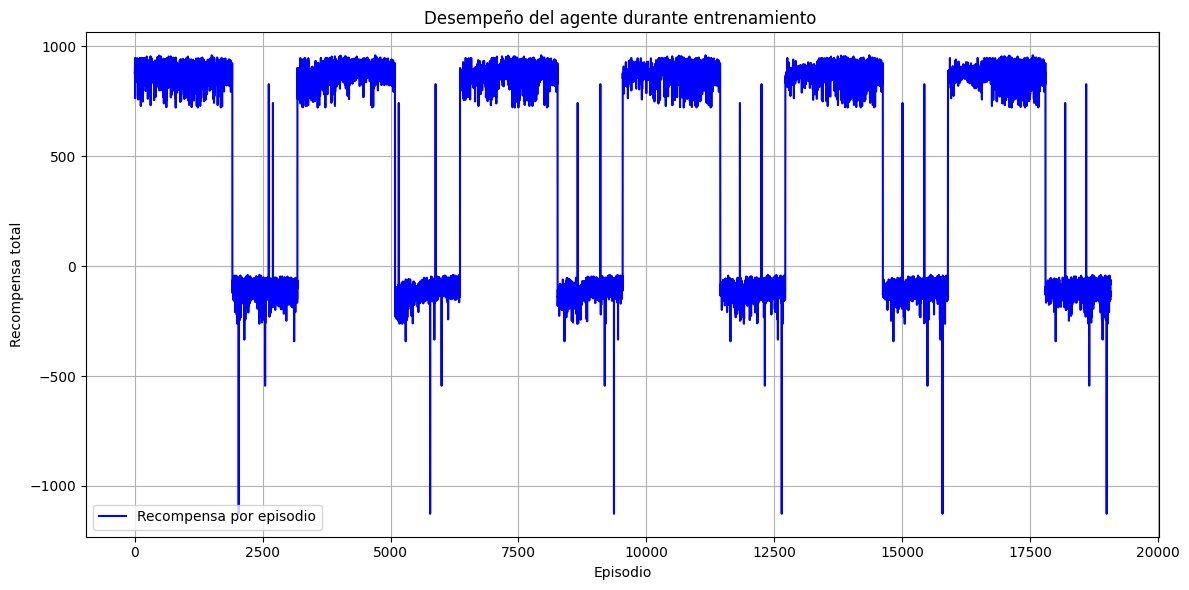

'# Personalización del gráfico\nplt.xlabel(\'Episodio\')\nplt.ylabel(\'Recompensa total\')\nplt.title(\'Desempeño del agente durante entrenamiento\')\nplt.legend()\nplt.grid(True)\nplt.tight_layout()\n\n# Guardar gráfico (antes de mostrar, sno, no se graba)\nplt.savefig("model_DeepCQL3_Pelt/score_cumplimientos.png", dpi=300)\n\nplt.show()'

In [49]:
import matplotlib.pyplot as plt
import pandas as pd

episodios = []
for df in estado['resultados_epochs']:
    for _, fila in df.iterrows():
        episodios.append(fila['score'])

# Crear figura
plt.figure(figsize=(12, 6))

# Línea azul: recompensa por episodio (en orden de aparición)
plt.plot(episodios, label='Recompensa por episodio', color='blue')

# Personalización del gráfico
plt.xlabel('Episodio')
plt.ylabel('Recompensa total')
plt.title('Desempeño del agente durante entrenamiento ')
plt.legend()
plt.grid(True)
plt.tight_layout()

# ✅ Guardar antes de mostrar
plt.savefig("model_DeepCQL3_Pelt/score_entrenamiento.png", dpi=300)

# Mostrar el gráfico
plt.show()

"""# Personalización del gráfico
plt.xlabel('Episodio')
plt.ylabel('Recompensa total')
plt.title('Desempeño del agente durante entrenamiento')
plt.legend()
plt.grid(True)
plt.tight_layout()

# Guardar gráfico (antes de mostrar, sno, no se graba)
plt.savefig("model_DeepCQL3_Pelt/score_cumplimientos.png", dpi=300)

plt.show()"""


✅ 2. Gráfica de scores del entrenamiento por epoch de resultados validados (cumplen objetivos)

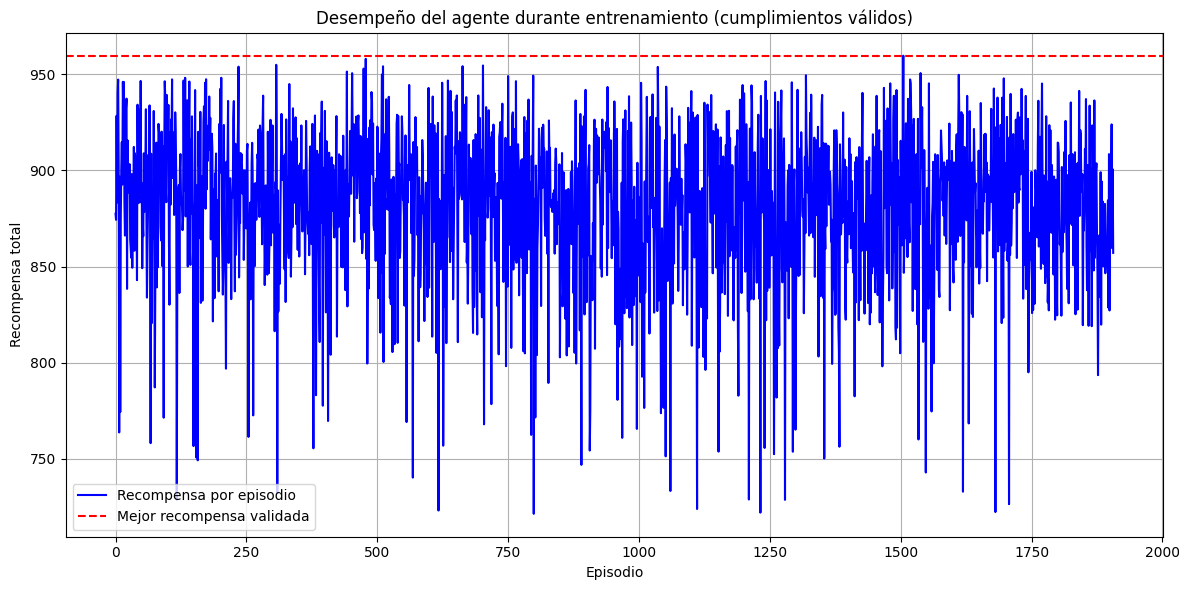

In [50]:
import pandas as pd
import matplotlib.pyplot as plt

df_cumplimientos = pd.read_csv("model_DeepCQL3_Pelt/cumplimientos.csv", sep=';', encoding='latin-1')
episodios = df_cumplimientos['score'].tolist()

plt.figure(figsize=(12, 6))
plt.plot(episodios, label='Recompensa por episodio', color='blue')
plt.axhline(y=max(episodios), color='red', linestyle='--', label='Mejor recompensa validada')

plt.xlabel('Episodio')
plt.ylabel('Recompensa total')
plt.title('Desempeño del agente durante entrenamiento (cumplimientos válidos)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("model_DeepCQL3_Pelt/score_cumplimientos.png", dpi=300)
plt.show()


✅ 3. Histograma de scores de todos los resultados

C:\Users\USER\AppData\Local\Temp\ipykernel_2120\2323044827.py:12: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\USER\AppData\Local\Temp\ipykernel_2120\2323044827.py:13: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.savefig("model_DeepCQL3_Pelt/histograma_scores_train.png", dpi=300)


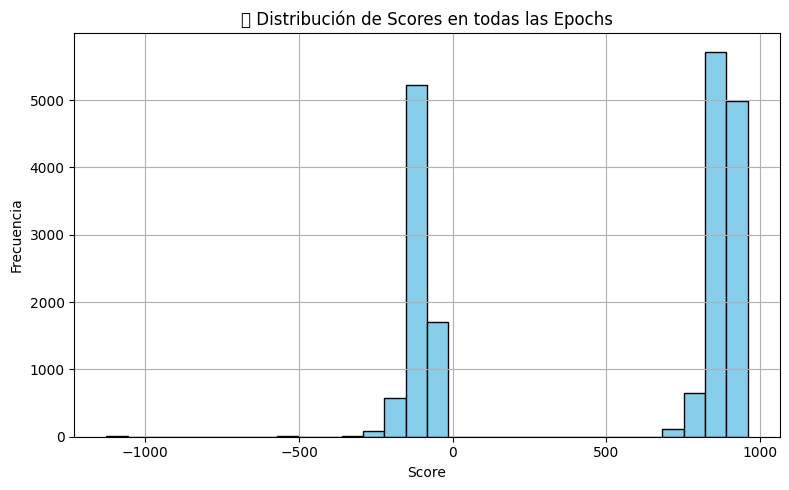

In [54]:
import pandas as pd

# Concatenar todos los resultados
todos_los_resultados = pd.concat(estado['resultados_epochs'], ignore_index=True)

plt.figure(figsize=(8, 5))
plt.hist(todos_los_resultados['score'], bins=30, color='skyblue', edgecolor='black')
plt.title("📊 Distribución de Scores en todas las Epochs")
plt.xlabel("Score")
plt.ylabel("Frecuencia")
plt.grid(True)
plt.tight_layout()
plt.savefig("model_DeepCQL3_Pelt/histograma_scores_train.png", dpi=300)
plt.show()

Muestra las Recompensas por pasos totales 

✅ 4. Histograma de scores de resultados validados (cumplimiento de objetivos)

C:\Users\USER\AppData\Local\Temp\ipykernel_2120\1392767994.py:17: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\USER\AppData\Local\Temp\ipykernel_2120\1392767994.py:20: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.savefig("model_DeepCQL3_Pelt/histograma_scores_validos.png", dpi=300)
c:\Users\USER\AppData\Local\Programs\Python\Python312\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


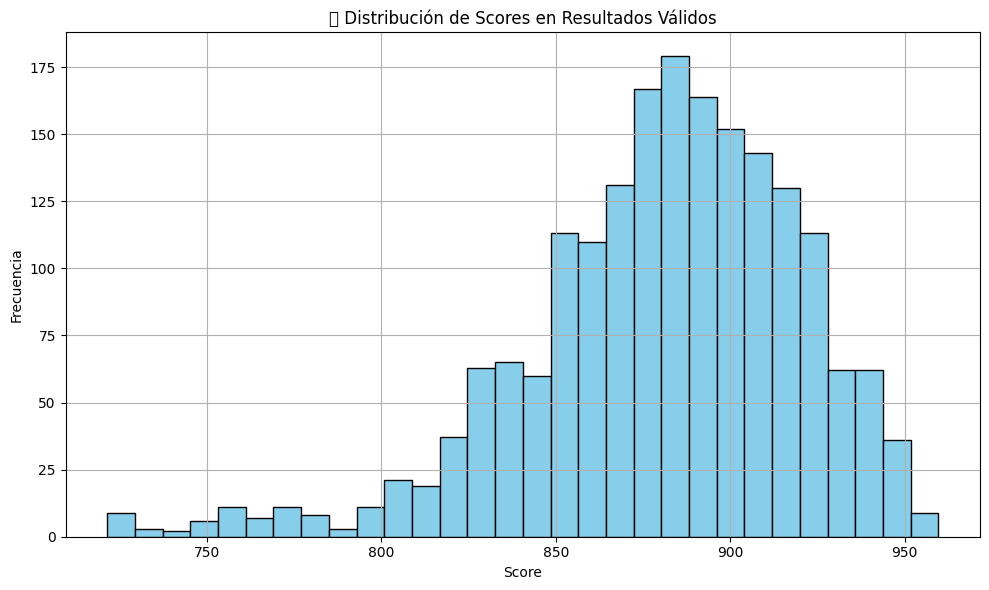

In [53]:
import pandas as pd
import matplotlib.pyplot as plt

# Leer solo los resultados válidos desde el archivo de cumplimientos
cumplimientos = pd.read_csv("model_DeepCQL3_Pelt/cumplimientos.csv", sep=';', encoding='latin-1')

# Asegurarse de que la columna 'score' existe y no contiene NaN
cumplimientos = cumplimientos.dropna(subset=['score'])

# Graficar el histograma de los scores válidos
plt.figure(figsize=(10, 6))
plt.hist(cumplimientos['score'], bins=30, color='skyblue', edgecolor='black')
plt.title("📊 Distribución de Scores en Resultados Válidos")
plt.xlabel("Score")
plt.ylabel("Frecuencia")
plt.grid(True)
plt.tight_layout()

# Guardar la figura
plt.savefig("model_DeepCQL3_Pelt/histograma_scores_validos.png", dpi=300)

# Mostrar la figura
plt.show()


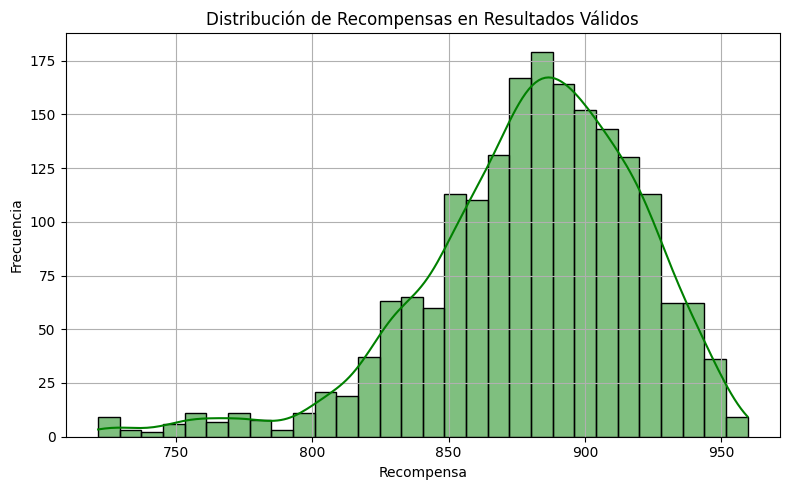

In [ ]:
import seaborn as sns

plt.figure(figsize=(8, 5))
sns.histplot(cumplimientos['score'], bins=30, kde=True, color='green')
plt.title("Distribución de Recompensas en Resultados Válidos")
plt.xlabel("Recompensa")
plt.ylabel("Frecuencia")
plt.grid(True)
plt.tight_layout()
plt.show()

* Gráfico 3D de Cumplimiento de objetivos : Productividad (Prodt) vs. Consumo de Vapor (Q_Vap) y porcentaje de finos(Fn)

C:\Users\USER\AppData\Local\Temp\ipykernel_2120\2067343515.py:41: UserWarning: Glyph 127760 (\N{GLOBE WITH MERIDIANS}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\USER\AppData\Local\Temp\ipykernel_2120\2067343515.py:45: UserWarning: Glyph 127760 (\N{GLOBE WITH MERIDIANS}) missing from font(s) DejaVu Sans.
  plt.savefig("model_DeepCQL3_Pelt/grafico_3D_objetivos_por_productividad.png", dpi=300)
c:\Users\USER\AppData\Local\Programs\Python\Python312\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 127760 (\N{GLOBE WITH MERIDIANS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


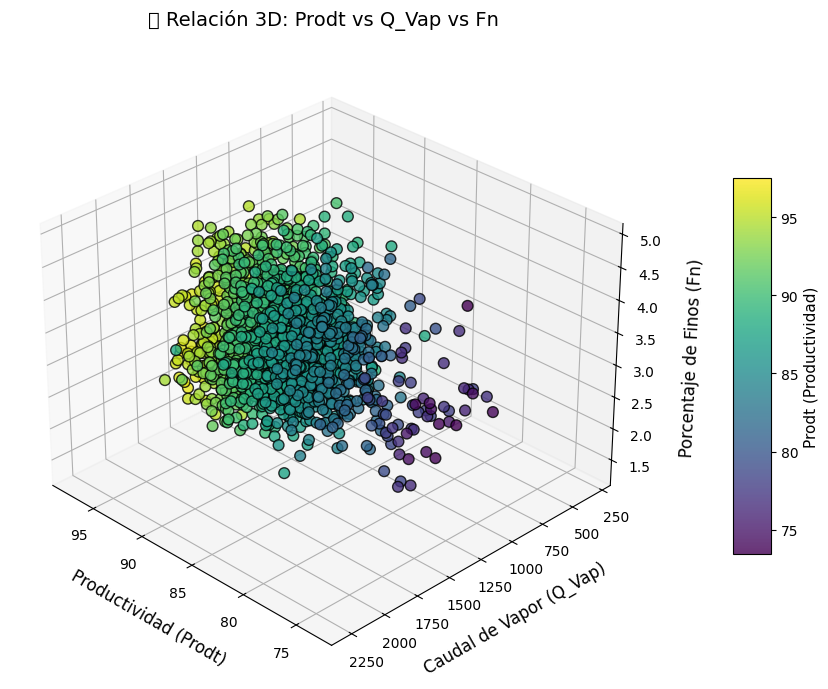

In [59]:
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.cm as cm
import numpy as np
import os

# Cargar los resultados válidos (cumplimientos)
df = pd.read_csv("model_DeepCQL3_Pelt/cumplimientos.csv", sep=';', encoding='latin-1')

# Eliminar filas con NaN en los objetivos
df = df.dropna(subset=['Prodt', 'Q_Vap', 'Fn'])

# Datos para el gráfico
x = df['Prodt']         # Productividad
y = df['Q_Vap']         # Caudal de vapor
z = df['Fn']            # % de Finos
color_variable = x      # La barra de color será en función de 'Prodt'
colors = cm.viridis((color_variable - color_variable.min()) / (color_variable.max() - color_variable.min()))

# Crear figura 3D
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

# Dibujar puntos
sc = ax.scatter(x, y, z, c=color_variable, cmap='viridis', s=60, edgecolor='k', alpha=0.8)

# Etiquetas y título
ax.set_xlabel("Productividad (Prodt)", fontsize=12, labelpad=10)
ax.set_ylabel("Caudal de Vapor (Q_Vap)", fontsize=12, labelpad=10)
ax.set_zlabel("Porcentaje de Finos (Fn)", fontsize=12, labelpad=10)
ax.set_title("🌐 Relación 3D: Prodt vs Q_Vap vs Fn", fontsize=14, pad=20)

# Barra de color en función de Prodt
cbar = fig.colorbar(sc, ax=ax, shrink=0.6, aspect=10, pad=0.1)
cbar.set_label("Prodt (Productividad)", fontsize=11)

# Ajustes visuales
ax.view_init(elev=30, azim=135)
ax.grid(True, linestyle='--', linewidth=0.5)
plt.tight_layout()

# Guardar imagen
os.makedirs("model_DeepCQL3_Pelt", exist_ok=True)
plt.savefig("model_DeepCQL3_Pelt/grafico_3D_objetivos_por_productividad.png", dpi=300)

# Mostrar gráfico
plt.show()


In [8]:
# Cargar los mejores cumplimientos (cumplimientos)
df_best = pd.read_csv("model_DeepCQL3_Pelt/mejor_cumplimiento.csv", sep=';', encoding='latin-1')

In [15]:

# Definir las columnas que quieres visualizar
columnas_deseadas = ['Prodt', 'Q_Vap','Fn', 'PDI', 'DGM', 'score','epoch', 'step']
columnas_deseadas1 = ['F_Alim', 'T_Alim', 'T_Vap', 'P_Vap', 'T_Acond', 't_ret','score','epoch', 'step']


# Filtrar solo esas columnas
df_best_1 = df_best[columnas_deseadas]
df_best_2 = df_best[columnas_deseadas1]

In [14]:
print("\n📋 Resultados de optimización de productividad y calidad encontrados:")
df_best_1.head() 


📋 Resultados de optimización de productividad y calidad encontrados:


,Prodt,Q_Vap,Fn,PDI,DGM,score,epoch,step
0,97.5,1535.72,2.47,92.2,3987,959.66,1,10000


In [17]:
print("\n📋 Parámetros de entrada para optimización de productividad y calidad:")
df_best_2.head() 


📋 Parámetros de entrada para optimización de productividad y calidad:


,F_Alim,T_Alim,T_Vap,P_Vap,T_Acond,t_ret,score,epoch,step
0,33.22,21.2,172.67,109.67,78,95,959.66,1,10000


In [60]:
import pandas as pd
import plotly.graph_objects as go
import os

# Cargar los datos
df = pd.read_csv("model_DeepCQL3_Pelt/cumplimientos.csv", sep=';', encoding='latin-1')

# Eliminar posibles valores nulos
df = df.dropna(subset=['Prodt', 'Q_Vap', 'Fn'])

# Crear gráfico 3D interactivo
fig = go.Figure(data=[go.Scatter3d(
    x=df['Prodt'],
    y=df['Q_Vap'],
    z=df['Fn'],
    mode='markers',
    marker=dict(
        size=6,
        color=df['Prodt'],  # Usar Prodt para color
        colorscale='Viridis',
        colorbar=dict(title='Productividad'),
        opacity=0.8,
        line=dict(width=0.5, color='DarkSlateGrey')
    ),
    text=[f"Prodt: {p:.3f}<br>Q_Vap: {q:.2f}<br>Fn: {f:.2f}"
          for p, q, f in zip(df['Prodt'], df['Q_Vap'], df['Fn'])]
)])

# Configurar layout
fig.update_layout(
    scene=dict(
        xaxis_title='Productividad (Prodt)',
        yaxis_title='Caudal de vapor (Q_Vap)',
        zaxis_title='Porcentaje de Finos (Fn)'
    ),
    title="🌐 Exploración 3D Interactiva: Prodt, Q_Vap y Fn",
    margin=dict(l=0, r=0, b=0, t=50),
    height=650
)

# Crear carpeta si no existe
os.makedirs("model_DeepCQL3_Pelt", exist_ok=True)

# Guardar como archivo interactivo HTML
fig.write_html("model_DeepCQL3_Pelt/grafico_3D_Prodt_Qvap_Fn.html")

# Mostrar en entorno interactivo
fig.show()


In [61]:
import pandas as pd
import plotly.graph_objects as go
import os

# Cargar los datos
df = pd.read_csv("model_DeepCQL3_Pelt/cumplimientos.csv", sep=';', encoding='latin-1')

# Eliminar posibles valores nulos
df = df.dropna(subset=['Prodt', 'Q_Vap', 'Fn'])

# Crear gráfico 3D interactivo
fig = go.Figure(data=[go.Scatter3d(
    x=df['Prodt'],
    y=df['Q_Vap'],
    z=df['Fn'],
    mode='markers',
    marker=dict(
        size=6,
        color=df['Prodt'],  # Usar Prodt para color
        colorscale='Viridis',
        colorbar=dict(title='Productividad'),
        opacity=0.8,
        line=dict(width=0.5, color='DarkSlateGrey')
    ),
    text=[f"Prodt: {p:.3f}<br>Q_Vap: {q:.2f}<br>Fn: {f:.2f}"
          for p, q, f in zip(df['Prodt'], df['Q_Vap'], df['Fn'])]
)])

# Configurar layout con más espacio en el borde inferior
fig.update_layout(
    scene=dict(
        xaxis_title='Productividad (Prodt)',
        yaxis_title='Caudal de vapor (Q_Vap)',
        zaxis_title='Porcentaje de Finos (Fn)'
    ),
    title="🌐 Exploración 3D Interactiva: Prodt, Q_Vap y Fn",
    margin=dict(l=0, r=0, b=80, t=60),  # Aumentado 'b' (bottom) de 0 a 80
    height=700  # Altura total ligeramente aumentada para mejor visualización
)

# Crear carpeta si no existe
os.makedirs("model_DeepCQL3_Pelt", exist_ok=True)

# Guardar como archivo interactivo HTML
fig.write_html("model_DeepCQL3_Pelt/grafico_3D_Prodt_Qvap_Fn.html")

# Mostrar en entorno interactivo
fig.show()


📚 Referencias bibliográficas (Norma Vancouver)\
Fujimoto S, Meger D, Precup D. Off-policy deep reinforcement learning without exploration. In Proceedings of the 36th International Conference on Machine Learning (ICML); 2019. p. 2052–2062.

Kumagai A, Ota K, Uno T, Fujita M, Matsumoto K, Sugiyama M. D3rlpy: An offline deep reinforcement learning library. Journal of Machine Learning Research. 2022;23(270):1–7.

Sutton RS, Barto AG. Reinforcement learning: An introduction. 2nd ed. Cambridge (MA): MIT Press; 2018.

Goodfellow I, Bengio Y, Courville A. Deep learning. Cambridge (MA): MIT Press; 2016.

García J, Fernández F. A comprehensive survey on safe reinforcement learning. Journal of Machine Learning Research. 2015;16:1437–88.

📌 Comentarios
La gráfica permite observar si el modelo mejora consistentemente o si converge demasiado pronto.

La tabla muestra los valores de acción (Fn, Q_Vap, Prodt) que llevaron a los mejores resultados bajo las restricciones de calidad (PDI, DGM).

El CSV exportado puede ser utilizado en Excel, Power BI o cualquier entorno de análisis adicional.

📚 Referencias bibliográficas (Norma Vancouver)\
Fujimoto S, Meger D, Precup D. Offline Reinforcement Learning: Tutorial, Review, and Perspectives on Open Problems. arXiv preprint arXiv:2105.12287. 2021.

Fujimoto S, Gu S, Turner R. Conservative Q-Learning for Offline Reinforcement Learning. NeurIPS 2020.

d3rlpy Project. D3RLpy: An Offline Deep Reinforcement Learning Library. https://github.com/takuseno/d3rlpy.

Ministerio del Ambiente del Perú. Estándares de Calidad Ambiental para Agua (ECAs). Decreto Supremo N° 004-2017-MINAM.



### ⚙️ ETAPA 2: Optimización Offline sobre Data Histórica (Simulada)
🎯 Objetivo General\
Evaluar cómo se comporta el mejor modelo Deep CQL entrenado (offline) al aplicar sus decisiones óptimas sobre datos históricos representativos del sistema real (por ejemplo, condiciones reales de operación pasadas de la planta). \
Esto permite estimar de forma segura y sin riesgo su capacidad de generalización, robustez y eficiencia operativa.

#### 1. Carga el modelo ya entrenado

In [ ]:

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from IPython.display import display, HTML
from d3rlpy.algos import ConservativeQL

In [ ]:
# === 1. Cargar modelo entrenado ===
modelo = ConservativeQL.from_json("best_model_deep_cql.json")
modelo.build()
modelo.load_model("model_DeepCQL2_Pelt/best_model_deep_cql.pt")


In [ ]:
# === 2. Cargar datos históricos correctamente ===
directorio_actual = os.getcwd()
archivo_csv = os.path.join(directorio_actual, "DPta_CarEngMxI&Q_6.0md1.csv")
data_Pelt = pd.read_csv(archivo_csv, encoding='latin1', sep=';')
data_historica = data_Pelt.copy()

In [ ]:
# === 3. Definir columnas ===
observation_columns = ['F_Alim', 'T_Alim', 'T_Vap', 'P_Vap', 'T_Acond', 't_ret', 'H_Pelt', 'T_Pelt', 'M_Vap', 'H_Add']
action_columns = ['Q_Vap', 'Fn', 'Prodt']
meta_columns = ['PDI', 'DGM']  # o las que uses como métricas

#### 2. Escalado de Observaciones

In [ ]:
# === 4. Reconstruir escaladores ===
scaler_obs = MinMaxScaler()
scaler_act = MinMaxScaler()
scaler_mets = MinMaxScaler()

obs = scaler_obs.fit_transform(data_Pelt[observation_columns].astype(np.float32))
act = scaler_act.fit_transform(data_Pelt[action_columns].astype(np.float32))
mets = scaler_mets.fit_transform(data_Pelt[meta_columns].astype(np.float32))

#### 3. Predicción de Acciones Óptimas

In [ ]:
# === 5. Escalar observaciones actuales y predecir acciones ===
X_hist = data_historica[observation_columns]
X_hist_scaled = scaler_obs.transform(X_hist)

acciones_optimas = modelo.predict(X_hist_scaled)
acciones_df = pd.DataFrame(acciones_optimas, columns=action_columns)

#### 4. Evaluación y simulación de  acciones

In [ ]:
# === 6. Funciones auxiliares necesarias ===
def simular_resultados(fila_estado, accion_pred): 
    accion_real = scaler_act.inverse_transform(accion_pred.reshape(1, -1)).ravel()
    fila_real = forzar_a_valor_real(accion_real, data_Pelt, action_columns)
    if fila_real is not None:
        fila_real = fila_real.copy()
        fila_real['score'] = calcular_recompensa(fila_real)
        return {
            "Prodt": fila_real["Prodt"],
            "PDI": fila_real["PDI"],
            "DGM": fila_real["DGM"],
            "Q_Vap": fila_real["Q_Vap"],
            "Fn": fila_real["Fn"],
            "score": fila_real["score"]
        }
    return None

In [ ]:
def evaluar_candidatos_mostrar_mejor_desde_df(
    acciones_df,
    fila_estado_base,
    scaler_act,
    data_Pelt,
    action_columns,
    guardar_csv=True,
    ruta_csv="mejor_decision_simulada.csv",
    graficar=False
):
    resultados = []
    for i in range(len(acciones_df)):
        accion_pred = acciones_df.iloc[i].values.astype(float)
        resultado = simular_resultados(fila_estado_base, accion_pred)
        if resultado is not None:
            resultados.append(resultado)

    if not resultados:
        print("❌ No se encontró ningún candidato válido.")
        return None, pd.DataFrame()

    resultados_df = pd.DataFrame(resultados)
    mejor_fila = resultados_df.sort_values(by="score", ascending=False).iloc[0]

    print("\n✅ 🎯 Mejor decisión simulada encontrada:")
    display(HTML(mejor_fila.to_frame().T.to_html(index=False)))

    if guardar_csv:
        mejor_fila.to_frame().T.to_csv(ruta_csv, index=False)
        print(f"\n💾 Mejor fila simulada guardada en: {ruta_csv}")

    if graficar:
        columnas_graficar = [col for col in mejor_fila.index if isinstance(mejor_fila[col], (int, float)) and col != 'score']
        mejor_fila[columnas_graficar].plot(kind='bar', figsize=(12, 5), title="🟢 Variables de la mejor acción simulada")
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.grid(True)
        plt.show()

    return mejor_fila, resultados_df


función completa y final, que:

Evalúa los candidatos con función de score (simple o rigurosa).

Muestra automáticamente en pantalla la mejor fila (horizontalmente).

Opcionalmente guarda esa mejor fila en CSV.

Grafica si deseas (puedes habilitarlo con un parámetro).

In [ ]:
# === 7. Definir fila base de simulación (última observación histórica) ===
fila_estado_actual = data_historica[observation_columns].iloc[-1]

### 5. Obtención de resultados y visualización

In [ ]:
# === 8. Ejecutar simulación de candidatos y mostrar mejor ===
mejor_fila_simulada, df_resultados_simulados = evaluar_candidatos_mostrar_mejor_desde_df(
    acciones_df=acciones_df,
    fila_estado_base=fila_estado_actual,
    scaler_act=scaler_act,
    data_Pelt=data_Pelt,
    action_columns=action_columns,
    guardar_csv=True,
    ruta_csv="mejor_decision_simulada.csv",
    graficar=True
)

ETAPA 2: Optimización Offline sobre Data Histórica, con los siguientes componentes:

Carga del modelo best_model_deep_cql.pkl.

Carga de la data histórica simulada.

Predicción con el modelo sobre cada muestra histórica.

Filtrado por condiciones requeridas.

Selección de la mejor fila según objetivos múltiples.

Visualización horizontal en pantalla.

Guardado en CSV y graficado.